In [3]:
# @title 1. Install Dependencies
!pip install -q ultralytics langchain-openai reportlab opencv-python-headless
!pip install -q git+https://github.com/facebookresearch/segment-anything.git

import os
import cv2
import sys
import json
import smtplib
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
from reportlab.lib import colors
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as ReportLabImage, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from google.colab import userdata

# Create directories
os.makedirs('/content/violations', exist_ok=True)
os.makedirs('/content/reports', exist_ok=True)

print("✅ Dependencies installed and directories created.")

  Preparing metadata (setup.py) ... done
✅ Dependencies installed and directories created.


In [ ]:
# @title 2. Global Configuration
class Config:
    # --- SITE INFO ---
    SITE_NAME = "Construction Site A(Demo)"
    SITE_LOCATION = "Zone 3, Building B(Demo)"
    COMPANY_NAME = "SafeBuild Construction Inc.(Demo)"

    # --- PATHS ---
    IMAGE_PATH = '/content/trade_top_section.webp'
    YOLO_WEIGHTS = '/content/best.pt'
    SAM_WEIGHTS = '/content/sam3.pt'
    VIOLATIONS_DIR = '/content/violations'
    REPORTS_DIR = '/content/reports'

    HF_TOKEN = "YOUR_HF_TOKEN"
    OPENAI_API_KEY = "YOUR_OPENAI_API_KEY"
    EMAIL_SENDER = "shezanahamed57@gmail.com"
    EMAIL_PASSWORD = "vhmx ozzb vihp aemf"
    EMAIL_RECIPIENTS = ["shezan.ahamed99@gmail.com"]

    # --- API KEYS (Try Colab Secrets first, else Manual) ---
    # try:
    #     HF_TOKEN = userdata.get('HF_TOKEN')
    #     OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
    #     EMAIL_SENDER = userdata.get('EMAIL_SENDER')
    #     EMAIL_PASSWORD = userdata.get('EMAIL_PASSWORD') # Gmail App Password
    #     EMAIL_RECIPIENTS = userdata.get('EMAIL_RECIPIENTS', '').split(',')
    # except:
    #     # FALLBACK: Enter keys here if not using Colab Secrets
    #     OPENAI_API_KEY = "sk-..."
    #     EMAIL_SENDER = "your_email@gmail.com"
    #     EMAIL_PASSWORD = "your_app_password"
    #     EMAIL_RECIPIENTS = ["manager@example.com"]

    # --- SETTINGS ---
    EMAIL_ENABLED = False # Set to True to actually send emails
    SAM_IMAGE_SIZE = 1024
    CONFIDENCE_THRESHOLD = 0.4

    # --- CLASS MAPPING ---
    TARGET_CLASSES = {
        'person': [6],
        'helmet': [1],
        'vest': [2],
        'no_helmet': [7]
    }

config = Config()
print(f"⚙️ Configuration loaded for {config.SITE_NAME}")

⚙️ Configuration loaded for Construction Site A(Demo)


In [5]:
from huggingface_hub import hf_hub_download, login
from huggingface_hub import login
login(new_session=False)

In [ ]:
#!wget --header="Authorization: Bearer YOUR_HF_TOKEN" "https://huggingface.co/facebook/sam3/resolve/main/sam3.pt"


In [7]:
# @title 3. Phase 1: Hierarchical Detection System
from ultralytics import YOLO
from ultralytics.models.sam import SAM3SemanticPredictor

class SafetyDetector:
    def __init__(self):
        print("🚀 Initializing Hierarchical Detection System...")
        self.yolo_model = YOLO(config.YOLO_WEIGHTS)

        # Load SAM 3
        overrides = dict(model=config.SAM_WEIGHTS, task="segment", mode="predict", conf=0.15)
        self.sam_model = SAM3SemanticPredictor(overrides=overrides)

        # Update Class IDs dynamically if possible
        names = self.yolo_model.names
        name_to_id = {v: k for k, v in names.items()}
        for key in config.TARGET_CLASSES:
            if key in name_to_id: config.TARGET_CLASSES[key] = [name_to_id[key]] # Fallback to strict map if key name differs

    def box_iou(self, box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        inter = max(0, x2 - x1) * max(0, y2 - y1)
        if inter == 0: return 0
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        return inter / box2_area

    def run_sam_rescue(self, image_path, search_prompts, roi_box, h, w):
        """Runs SAM only on ROI"""
        try:
            res = self.sam_model(image_path, text=search_prompts, imgsz=config.SAM_IMAGE_SIZE, verbose=False)
            if not res[0].masks: return False
            masks = [m.cpu().numpy().astype(np.uint8) for m in res[0].masks.data]
            for m in masks:
                if m.shape[:2] != (h, w): m = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)
                roi = m[roi_box[1]:roi_box[3], roi_box[0]:roi_box[2]]
                if np.sum(roi) > 0: return True
        except: pass
        return False

    def detect(self, image_path):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # --- YOLO SCAN ---
        results = self.yolo_model.predict(image_path, conf=config.CONFIDENCE_THRESHOLD, verbose=False)
        detections = {'person': [], 'helmet': [], 'vest': [], 'no_helmet': []}

        for box in results[0].boxes:
            cls = int(box.cls[0])
            coords = box.xyxy[0].cpu().numpy().astype(int)
            # Map YOLO classes to our buckets
            for key, ids in config.TARGET_CLASSES.items():
                if cls in ids: detections[key].append(coords)

        violations = []

        # --- HIERARCHICAL LOGIC ---
        for p_box in detections['person']:
            has_helmet, has_vest, unsafe_explicit = False, False, False

            # Check Overlaps
            for eq in detections['helmet']:
                if self.box_iou(p_box, eq) > 0.3: has_helmet = True
            for eq in detections['vest']:
                if self.box_iou(p_box, eq) > 0.3: has_vest = True
            for eq in detections['no_helmet']:
                if self.box_iou(p_box, eq) > 0.3: unsafe_explicit = True

            status = "SAFE"
            missing = []

            # 1. Fast Unsafe
            if unsafe_explicit:
                status = "UNSAFE"
                missing.append("Helmet")

            # 2. Fast Safe
            elif has_helmet and has_vest:
                status = "SAFE"

            # 3. Rescue Vest
            elif has_helmet and not has_vest:
                body_roi = [p_box[0], int(p_box[1] + (p_box[3]-p_box[1])*0.2), p_box[2], p_box[3]]
                if not self.run_sam_rescue(image_path, ["vest"], body_roi, h, w):
                    status = "UNSAFE"
                    missing.append("Vest")

            # 4. Rescue Helmet
            elif has_vest and not has_helmet:
                head_roi = [p_box[0], p_box[1], p_box[2], int(p_box[1] + (p_box[3]-p_box[1])*0.4)]
                if not self.run_sam_rescue(image_path, ["helmet"], head_roi, h, w):
                    status = "UNSAFE"
                    missing.append("Helmet")

            # 5. Full Rescue
            else:
                head_roi = [p_box[0], p_box[1], p_box[2], int(p_box[1] + (p_box[3]-p_box[1])*0.4)]
                body_roi = [p_box[0], int(p_box[1] + (p_box[3]-p_box[1])*0.2), p_box[2], p_box[3]]
                found_h = self.run_sam_rescue(image_path, ["helmet"], head_roi, h, w)
                found_v = self.run_sam_rescue(image_path, ["vest"], body_roi, h, w)

                if not found_h or not found_v:
                    status = "UNSAFE"
                    if not found_h: missing.append("Helmet")
                    if not found_v: missing.append("Vest")

            # --- LOG VIOLATION IF UNSAFE ---
            if status == "UNSAFE":
                timestamp = datetime.now()
                # Draw box on copy of image for report
                evidence_img = img_rgb.copy()
                cv2.rectangle(evidence_img, (p_box[0], p_box[1]), (p_box[2], p_box[3]), (255, 0, 0), 3)

                evidence_path = f"{config.VIOLATIONS_DIR}/violation_{timestamp.strftime('%H%M%S')}.jpg"
                cv2.imwrite(evidence_path, cv2.cvtColor(evidence_img, cv2.COLOR_RGB2BGR))

                violation_data = {
                    "timestamp": timestamp,
                    "location": config.SITE_LOCATION,
                    "description": f"Worker detected without {', '.join(missing)}",
                    "missing_items": missing,
                    "confidence": 0.85, # Aggregate confidence
                    "image_path": evidence_path,
                    "bbox": p_box
                }
                violations.append(violation_data)

        return violations

detector = SafetyDetector()
print("✅ Detector Ready")

🚀 Initializing Hierarchical Detection System...
✅ Detector Ready


In [8]:
# @title 4. Phase 2: AI Compliance Agent
class ComplianceAgent:
    def __init__(self):
        self.has_key = config.OPENAI_API_KEY and config.OPENAI_API_KEY.startswith("sk-")
        if self.has_key:
            self.llm = ChatOpenAI(model="gpt-4", openai_api_key=config.OPENAI_API_KEY, temperature=0.3)
            self.prompt = PromptTemplate(
                input_variables=["date", "time", "location", "description", "missing"],
                template="""
                    You are an OSHA Safety Compliance Officer.
                    Details: {date} at {location}.
                    Violation: {description}. Missing: {missing}.

                    Generate a Citation Report Section:
                    1. **Regulation Cited:** (Map '{missing}' to specific OSHA 1926 codes).
                    2. **Observation:** (Professional description of the worker's non-compliance).
                    3. **Severity:** (High/Medium/Low based on the missing gear).
                    4. **Required Action:** (Immediate corrective steps).
                    """
            )
        else:
            print("⚠️ Agent initialized in MOCK mode (No API Key)")

    def generate_report_text(self, violation):
        if not self.has_key:
            return f"""
            **MOCK AI REPORT**
            **Incident:** {violation['description']} detected at {violation['location']}.
            **Regulation:** Likely violates OSHA 1926.100 (Head Protection) or 1926.102 (PPE).
            **Action:** Immediately halt work and provide required PPE to the worker.
            """

        try:
            chain = self.prompt | self.llm
            response = chain.invoke({
                "date": violation['timestamp'].strftime("%Y-%m-%d"),
                "time": violation['timestamp'].strftime("%H:%M:%S"),
                "location": violation['location'],
                "description": violation['description'],
                "missing": ", ".join(violation['missing_items'])
            })
            return response.content
        except Exception as e:
            return f"Error generating AI report: {e}"

agent = ComplianceAgent()
print("✅ Agent Ready")

✅ Agent Ready


In [9]:
# @title 5. Phase 3: PDF Report Generator
class PDFGenerator:
    def generate_pdf(self, violation, report_text):
        filename = f"{config.REPORTS_DIR}/Incident_{violation['timestamp'].strftime('%Y%m%d_%H%M%S')}.pdf"
        doc = SimpleDocTemplate(filename, pagesize=letter)
        styles = getSampleStyleSheet()
        story = []

        # Header
        story.append(Paragraph(f"SAFETY INCIDENT REPORT", styles['Title']))
        story.append(Spacer(1, 12))

        # Meta Data Table
        data = [
            ["Date:", violation['timestamp'].strftime("%Y-%m-%d %H:%M:%S")],
            ["Site:", config.SITE_NAME],
            ["Location:", config.SITE_LOCATION],
            ["Violation Type:", violation['description']]
        ]
        t = Table(data, colWidths=[100, 300])
        t.setStyle(TableStyle([('FONT', (0,0), (-1,-1), 'Helvetica-Bold'), ('GRID', (0,0), (-1,-1), 1, colors.black)]))
        story.append(t)
        story.append(Spacer(1, 20))

        # Evidence Image
        if os.path.exists(violation['image_path']):
            im = ReportLabImage(violation['image_path'], width=400, height=300)
            story.append(im)
            story.append(Paragraph("Fig 1. Automated Detection Evidence", styles['Italic']))
            story.append(Spacer(1, 20))

        # AI Analysis Section
        story.append(Paragraph("Officer Analysis (AI Generated):", styles['Heading2']))
        story.append(Paragraph(report_text.replace("\n", "<br/>"), styles['Normal']))

        # Footer
        story.append(Spacer(1, 30))
        story.append(Paragraph(f"Generated by {config.COMPANY_NAME} Safety System", styles['Italic']))

        doc.build(story)
        print(f"📄 PDF Generated: {filename}")
        return filename

pdf_gen = PDFGenerator()
print("✅ PDF Generator Ready")

✅ PDF Generator Ready


In [10]:
# @title 6. Phase 4: Email Notification System
class NotificationService:
    def send_email(self, violation, pdf_path):
        if not config.EMAIL_ENABLED:
            print(f"📧 EMAIL SKIPPED (Config Disabled). Report saved at {pdf_path}")
            return

        msg = MIMEMultipart()
        msg['From'] = config.EMAIL_SENDER
        msg['To'] = ", ".join(config.EMAIL_RECIPIENTS)
        msg['Subject'] = f"🚨 Safety Violation: {violation['description']}"

        body = f"""
        URGENT: Safety Violation Detected

        Site: {config.SITE_NAME}
        Time: {violation['timestamp']}
        Violation: {violation['description']}

        Please see attached official report.
        """
        msg.attach(MIMEText(body, 'plain'))

        with open(pdf_path, "rb") as f:
            attach = MIMEApplication(f.read(), _subtype="pdf")
            attach.add_header('Content-Disposition', 'attachment', filename=os.path.basename(pdf_path))
            msg.attach(attach)

        try:
            server = smtplib.SMTP('smtp.gmail.com', 587)
            server.starttls()
            server.login(config.EMAIL_SENDER, config.EMAIL_PASSWORD)
            server.send_message(msg)
            server.quit()
            print(f"✅ Email Sent to {config.EMAIL_RECIPIENTS}")
        except Exception as e:
            print(f"❌ Email Failed: {e}")

notifier = NotificationService()
print("✅ Notification Service Ready")

✅ Notification Service Ready


In [11]:
# @title 7. Run Full Ecosystem
def run_safety_ecosystem(image_path):
    print("="*60)
    print("🎬 STARTING SAFETY AUDIT PIPELINE")
    print("="*60)

    # 1. DETECT
    print("\n🔍 PHASE 1: Detection")
    violations = detector.detect(image_path)

    if not violations:
        print("✅ No violations detected. Site is safe.")
        return

    print(f"⚠️  Found {len(violations)} Violations. Processing...")

    for v in violations:
        print(f"   👉 Processing: {v['description']}")

        # 2. AGENT
        print("   🤖 PHASE 2: AI Agent Analysis")
        report_text = agent.generate_report_text(v)

        # 3. REPORT
        print("   📄 PHASE 3: Generating Documents")
        pdf_path = pdf_gen.generate_pdf(v, report_text)

        # 4. NOTIFY
        print("   Aa PHASE 4: Notification")
        notifier.send_email(v, pdf_path)

    print("\n✅ PIPELINE COMPLETE")
    print("="*60)

# Run it
if os.path.exists(config.IMAGE_PATH):
    run_safety_ecosystem(config.IMAGE_PATH)
else:
    print(f"❌ Error: Image not found at {config.IMAGE_PATH}")

🎬 STARTING SAFETY AUDIT PIPELINE

🔍 PHASE 1: Detection
✅ No violations detected. Site is safe.


In [12]:
def visualize_roi_extraction(image_path, person_bbox):
    """
    Annotate image showing head and torso ROIs
    """
    import cv2

    img = cv2.imread(image_path)
    x_min, y_min, x_max, y_max = person_bbox

    # Draw person bbox (blue)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 3)
    cv2.putText(img, 'Person', (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # Calculate and draw head ROI (red)
    head_y_max = int(y_min + 0.4 * (y_max - y_min))
    cv2.rectangle(img, (x_min, y_min), (x_max, head_y_max), (0, 0, 255), 2)
    cv2.putText(img, 'Head ROI (40%)', (x_min, y_min+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    # Calculate and draw torso ROI (green)
    width = x_max - x_min
    height = y_max - y_min
    torso_x_min = int(x_min + 0.15 * width)
    torso_x_max = int(x_max - 0.15 * width)
    torso_y_min = int(y_min + 0.3 * height)
    torso_y_max = int(y_min + 0.7 * height)
    cv2.rectangle(img, (torso_x_min, torso_y_min), (torso_x_max, torso_y_max), (0, 255, 0), 2)
    cv2.putText(img, 'Torso ROI', (torso_x_min, torso_y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    cv2.imwrite('roi_extraction_demo.png', img)


def yolo_person_detection_bbox_return(image_path):
  model = YOLO("best.pt")
  results = model.predict(image_path, classes=6, verbose=False)
  person_bboxes = []
  for box in results[0].boxes:
    coords = box.xyxy[0].cpu().numpy().astype(int)
    person_bboxes.append(coords)
  return person_bboxes
image_path='/content/female-construction-worker-without-helmet-260nw-2567321355.webp'
person_bbox = yolo_person_detection_bbox_return(image_path)
visualize_roi_extraction(image_path, person_bbox[0])

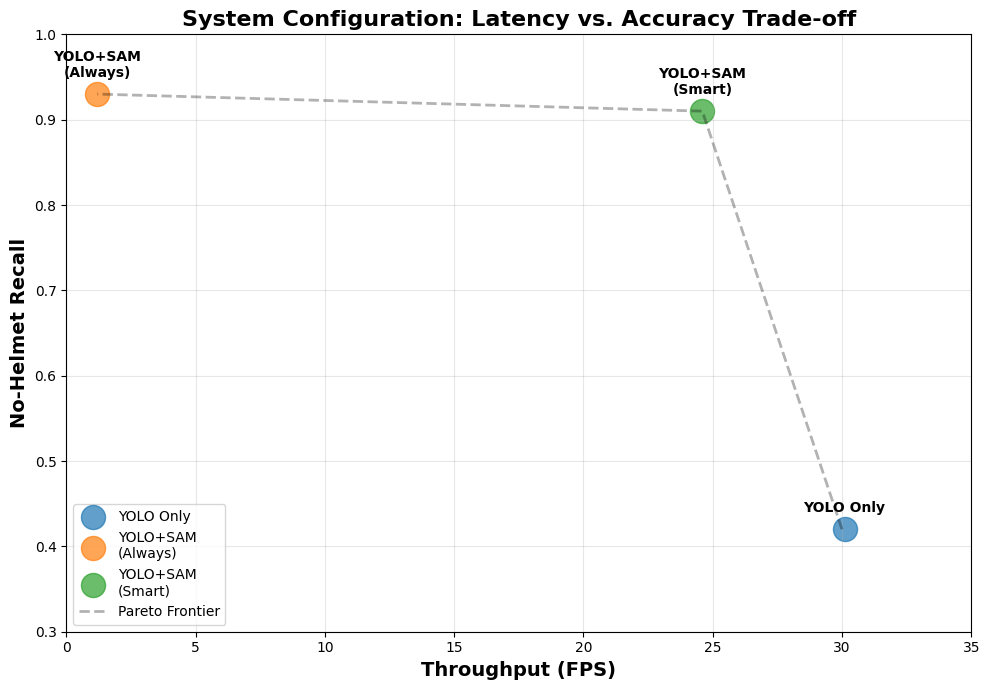

In [13]:
def plot_throughput_accuracy_tradeoff(configs):
    """
    Scatter plot showing latency-accuracy Pareto frontier
    """
    fig, ax = plt.subplots(figsize=(10, 7))

    for config in configs:
        ax.scatter(config['fps'], config['recall'], s=300, alpha=0.7, label=config['name'])
        ax.text(config['fps'], config['recall'] + 0.02, config['name'],
                ha='center', fontsize=10, fontweight='bold')

    # Draw Pareto frontier
    pareto_fps = [30, 24.6, 1.2]
    pareto_recall = [0.42, 0.91, 0.93]
    ax.plot(pareto_fps, pareto_recall, 'k--', alpha=0.3, linewidth=2, label='Pareto Frontier')

    ax.set_xlabel('Throughput (FPS)', fontsize=14, fontweight='bold')
    ax.set_ylabel('No-Helmet Recall', fontsize=14, fontweight='bold')
    ax.set_title('System Configuration: Latency vs. Accuracy Trade-off', fontsize=16, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend(loc='lower left', fontsize=10)
    ax.set_xlim(0, 35)
    ax.set_ylim(0.3, 1.0)

    plt.tight_layout()
    plt.savefig('throughput_accuracy_tradeoff.png', dpi=300)

# Example data
configs = [
    {'name': 'YOLO Only', 'fps': 30.1, 'recall': 0.42},
    {'name': 'YOLO+SAM\n(Always)', 'fps': 1.2, 'recall': 0.93},
    {'name': 'YOLO+SAM\n(Smart)', 'fps': 24.6, 'recall': 0.91},
]
plot_throughput_accuracy_tradeoff(configs)

In [14]:
# @title 3. Phase 1: Hierarchical Detection System
from ultralytics import YOLO
from ultralytics.models.sam import SAM3SemanticPredictor

class SafetyDetector:
    def __init__(self):
        print("🚀 Initializing Hierarchical Detection System...")
        self.yolo_model = YOLO(config.YOLO_WEIGHTS)

        # Load SAM 3
        overrides = dict(model=config.SAM_WEIGHTS, task="segment", mode="predict", conf=0.15)
        self.sam_model = SAM3SemanticPredictor(overrides=overrides)

        # Update Class IDs dynamically if possible
        names = self.yolo_model.names
        name_to_id = {v: k for k, v in names.items()}
        for key in config.TARGET_CLASSES:
            if key in name_to_id: config.TARGET_CLASSES[key] = [name_to_id[key]] # Fallback to strict map if key name differs

    def box_iou(self, box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        inter = max(0, x2 - x1) * max(0, y2 - y1)
        if inter == 0: return 0
        box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
        return inter / box2_area

    def run_sam_rescue(self, image_path, search_prompts, roi_box, h, w):
        """Runs SAM only on ROI"""
        try:
            res = self.sam_model(image_path, text=search_prompts, imgsz=config.SAM_IMAGE_SIZE, verbose=False)
            if not res[0].masks: return False
            masks = [m.cpu().numpy().astype(np.uint8) for m in res[0].masks.data]
            for m in masks:
                if m.shape[:2] != (h, w): m = cv2.resize(m, (w, h), interpolation=cv2.INTER_NEAREST)
                roi = m[roi_box[1]:roi_box[3], roi_box[0]:roi_box[2]]
                if np.sum(roi) > 0: return True
        except: pass
        return False

    def detect(self, image_path):
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # --- YOLO SCAN ---
        results = self.yolo_model.predict(image_path, conf=config.CONFIDENCE_THRESHOLD, verbose=False)
        detections = {'person': [], 'helmet': [], 'vest': [], 'no_helmet': []}

        for box in results[0].boxes:
            cls = int(box.cls[0])
            coords = box.xyxy[0].cpu().numpy().astype(int)
            # Map YOLO classes to our buckets
            for key, ids in config.TARGET_CLASSES.items():
                if cls in ids: detections[key].append(coords)

        violations = []

        # --- HIERARCHICAL LOGIC ---
        for p_box in detections['person']:
            has_helmet, has_vest, unsafe_explicit = False, False, False

            # Check Overlaps
            for eq in detections['helmet']:
                if self.box_iou(p_box, eq) > 0.3: has_helmet = True
            for eq in detections['vest']:
                if self.box_iou(p_box, eq) > 0.3: has_vest = True
            for eq in detections['no_helmet']:
                if self.box_iou(p_box, eq) > 0.3: unsafe_explicit = True

            status = "SAFE"
            missing = []

            # 1. Fast Unsafe
            if unsafe_explicit:
                status = "UNSAFE"
                missing.append("Helmet")

            # 2. Fast Safe
            elif has_helmet and has_vest:
                status = "SAFE"

            # 3. Rescue Vest
            elif has_helmet and not has_vest:
                body_roi = [p_box[0], int(p_box[1] + (p_box[3]-p_box[1])*0.2), p_box[2], p_box[3]]
                if not self.run_sam_rescue(image_path, ["vest"], body_roi, h, w):
                    status = "UNSAFE"
                    missing.append("Vest")

            # 4. Rescue Helmet
            elif has_vest and not has_helmet:
                head_roi = [p_box[0], p_box[1], p_box[2], int(p_box[1] + (p_box[3]-p_box[1])*0.4)]
                if not self.run_sam_rescue(image_path, ["helmet"], head_roi, h, w):
                    status = "UNSAFE"
                    missing.append("Helmet")

            # 5. Full Rescue
            else:
                head_roi = [p_box[0], p_box[1], p_box[2], int(p_box[1] + (p_box[3]-p_box[1])*0.4)]
                body_roi = [p_box[0], int(p_box[1] + (p_box[3]-p_box[1])*0.2), p_box[2], p_box[3]]
                found_h = self.run_sam_rescue(image_path, ["helmet"], head_roi, h, w)
                found_v = self.run_sam_rescue(image_path, ["vest"], body_roi, h, w)

                if not found_h or not found_v:
                    status = "UNSAFE"
                    if not found_h: missing.append("Helmet")
                    if not found_v: missing.append("Vest")

            # --- LOG VIOLATION IF UNSAFE ---
            if status == "UNSAFE":
                timestamp = datetime.now()
                # Draw box on copy of image for report
                evidence_img = img_rgb.copy()
                cv2.rectangle(evidence_img, (p_box[0], p_box[1]), (p_box[2], p_box[3]), (255, 0, 0), 3)

                evidence_path = f"{config.VIOLATIONS_DIR}/violation_{timestamp.strftime('%H%M%S')}.jpg"
                cv2.imwrite(evidence_path, cv2.cvtColor(evidence_img, cv2.COLOR_RGB2BGR))

                violation_data = {
                    "timestamp": timestamp,
                    "location": config.SITE_LOCATION,
                    "description": f"Worker detected without {', '.join(missing)}",
                    "missing_items": missing,
                    "confidence": 0.85, # Aggregate confidence
                    "image_path": evidence_path,
                    "bbox": p_box
                }
                violations.append(violation_data)

        return violations

detector = SafetyDetector()
print("✅ Detector Ready")

🚀 Initializing Hierarchical Detection System...
✅ Detector Ready


In [15]:
# @title 3.1 Enhanced Detector with Path Tracking
from collections import Counter
import glob

class EnhancedSafetyDetector(SafetyDetector):
    """Extended detector that tracks decision paths for analysis"""

    def __init__(self):
        super().__init__()
        self.decision_paths = []

    def detect_with_tracking(self, image_path):
        """Run detection and track which decision paths are taken"""
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img_rgb.shape[:2]

        # --- YOLO SCAN ---
        results = self.yolo_model.predict(image_path, conf=config.CONFIDENCE_THRESHOLD, verbose=False)
        detections = {'person': [], 'helmet': [], 'vest': [], 'no_helmet': []}

        for box in results[0].boxes:
            cls = int(box.cls[0])
            coords = box.xyxy[0].cpu().numpy().astype(int)
            for key, ids in config.TARGET_CLASSES.items():
                if cls in ids: detections[key].append(coords)

        violations = []
        frame_paths = []

        # --- HIERARCHICAL LOGIC WITH PATH TRACKING ---
        for p_box in detections['person']:
            has_helmet, has_vest, unsafe_explicit = False, False, False

            # Check Overlaps
            for eq in detections['helmet']:
                if self.box_iou(p_box, eq) > 0.3: has_helmet = True
            for eq in detections['vest']:
                if self.box_iou(p_box, eq) > 0.3: has_vest = True
            for eq in detections['no_helmet']:
                if self.box_iou(p_box, eq) > 0.3: unsafe_explicit = True

            status = "SAFE"
            missing = []
            decision_path = ""

            # 1. Fast Unsafe (Fast Violation Path)
            if unsafe_explicit:
                status = "UNSAFE"
                missing.append("Helmet")
                decision_path = "Fast Violation"

            # 2. Fast Safe
            elif has_helmet and has_vest:
                status = "SAFE"
                decision_path = "Fast Safe"

            # 3. Rescue Vest (Rescue Body Path)
            elif has_helmet and not has_vest:
                decision_path = "Rescue Body"
                body_roi = [p_box[0], int(p_box[1] + (p_box[3]-p_box[1])*0.2), p_box[2], p_box[3]]
                if not self.run_sam_rescue(image_path, ["vest"], body_roi, h, w):
                    status = "UNSAFE"
                    missing.append("Vest")

            # 4. Rescue Helmet (Rescue Head Path)
            elif has_vest and not has_helmet:
                decision_path = "Rescue Head"
                head_roi = [p_box[0], p_box[1], p_box[2], int(p_box[1] + (p_box[3]-p_box[1])*0.4)]
                if not self.run_sam_rescue(image_path, ["helmet"], head_roi, h, w):
                    status = "UNSAFE"
                    missing.append("Helmet")

            # 5. Full Rescue (Critical Path)
            else:
                decision_path = "Critical"
                head_roi = [p_box[0], p_box[1], p_box[2], int(p_box[1] + (p_box[3]-p_box[1])*0.4)]
                body_roi = [p_box[0], int(p_box[1] + (p_box[3]-p_box[1])*0.2), p_box[2], p_box[3]]
                found_h = self.run_sam_rescue(image_path, ["helmet"], head_roi, h, w)
                found_v = self.run_sam_rescue(image_path, ["vest"], body_roi, h, w)

                if not found_h or not found_v:
                    status = "UNSAFE"
                    if not found_h: missing.append("Helmet")
                    if not found_v: missing.append("Vest")

            # Track the decision path
            frame_paths.append(decision_path)

            # --- LOG VIOLATION IF UNSAFE ---
            if status == "UNSAFE":
                timestamp = datetime.now()
                evidence_img = img_rgb.copy()
                cv2.rectangle(evidence_img, (p_box[0], p_box[1]), (p_box[2], p_box[3]), (255, 0, 0), 3)

                evidence_path = f"{config.VIOLATIONS_DIR}/violation_{timestamp.strftime('%H%M%S')}.jpg"
                cv2.imwrite(evidence_path, cv2.cvtColor(evidence_img, cv2.COLOR_RGB2BGR))

                violation_data = {
                    "timestamp": timestamp,
                    "location": config.SITE_LOCATION,
                    "description": f"Worker detected without {', '.join(missing)}",
                    "missing_items": missing,
                    "confidence": 0.85,
                    "image_path": evidence_path,
                    "bbox": p_box,
                    "decision_path": decision_path
                }
                violations.append(violation_data)

        # Store paths for this frame
        self.decision_paths.extend(frame_paths)

        return violations, frame_paths

# Initialize enhanced detector
enhanced_detector = EnhancedSafetyDetector()
print("✅ Enhanced Detector with Path Tracking Ready")

🚀 Initializing Hierarchical Detection System...
✅ Enhanced Detector with Path Tracking Ready


In [16]:
def analyze_sam_activation(test_results):
    """
    Show which paths are taken across test set
    """
    path_counts = Counter(test_results['decision_paths'])

    paths = ['Fast Safe', 'Fast Violation', 'Rescue Head', 'Rescue Body', 'Critical']
    counts = [path_counts.get(p, 0) for p in paths]
    percentages = [c/sum(counts)*100 for c in counts]

    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(paths, percentages, color=['green', 'red', 'yellow', 'orange', 'darkred'])

    # Add percentage labels
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_ylabel('Percentage of Test Frames (%)', fontsize=12)
    ax.set_xlabel('Decision Path', fontsize=12)
    ax.set_title('Distribution of Decision Paths Across Test Set', fontsize=14, fontweight='bold')
    ax.axhline(y=15, color='blue', linestyle='--', label='SAM Activation Threshold (15%)', linewidth=2)
    ax.legend()
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.savefig('figures/sam_activation_distribution.png', dpi=300)

In [17]:
# @title 8. Test SAM Activation Analysis on Dataset
import os
from collections import Counter

def run_path_analysis_on_testset(test_images_dir):
    """
    Run detection on entire test set and track decision paths
    """
    print("="*60)
    print("🔬 STARTING SAM ACTIVATION ANALYSIS")
    print("="*60)

    # Reset path tracking
    enhanced_detector.decision_paths = []

    # Get all test images
    test_images = glob.glob(f"{test_images_dir}/*.jpg") + \
                  glob.glob(f"{test_images_dir}/*.png") + \
                  glob.glob(f"{test_images_dir}/*.webp")

    print(f"📸 Found {len(test_images)} test images")

    all_violations = []

    # Process each image
    for idx, img_path in enumerate(test_images):
        if idx % 10 == 0:
            print(f"   Processing image {idx+1}/{len(test_images)}...")

        try:
            violations, frame_paths = enhanced_detector.detect_with_tracking(img_path)
            all_violations.extend(violations)
        except Exception as e:
            print(f"   ⚠️ Error processing {img_path}: {e}")
            continue

    print(f"\n✅ Analysis Complete!")
    print(f"   Total Persons Detected: {len(enhanced_detector.decision_paths)}")
    print(f"   Total Violations Found: {len(all_violations)}")

    # Create results dictionary
    test_results = {
        'decision_paths': enhanced_detector.decision_paths,
        'violations': all_violations,
        'total_images': len(test_images)
    }

    return test_results

def analyze_sam_activation(test_results):
    """
    Show which paths are taken across test set
    """
    path_counts = Counter(test_results['decision_paths'])

    paths = ['Fast Safe', 'Fast Violation', 'Rescue Head', 'Rescue Body', 'Critical']
    counts = [path_counts.get(p, 0) for p in paths]
    total = sum(counts)
    percentages = [c/total*100 if total > 0 else 0 for c in counts]

    # Print statistics
    print("\n" + "="*60)
    print("📊 DECISION PATH DISTRIBUTION")
    print("="*60)
    for path, count, pct in zip(paths, counts, percentages):
        print(f"   {path:20s}: {count:4d} ({pct:5.1f}%)")

    # Calculate SAM activation rate
    sam_paths = ['Rescue Head', 'Rescue Body', 'Critical']
    sam_count = sum([path_counts.get(p, 0) for p in sam_paths])
    sam_percentage = (sam_count / total * 100) if total > 0 else 0
    print(f"\n   {'SAM ACTIVATION RATE':20s}: {sam_count:4d} ({sam_percentage:5.1f}%)")
    print("="*60)

    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(paths, percentages, color=['green', 'red', 'yellow', 'orange', 'darkred'])

    # Add percentage labels
    for bar, pct in zip(bars, percentages):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

    ax.set_ylabel('Percentage of Detected Persons (%)', fontsize=12)
    ax.set_xlabel('Decision Path', fontsize=12)
    ax.set_title('Distribution of Decision Paths Across Test Set', fontsize=14, fontweight='bold')
    ax.axhline(y=15, color='blue', linestyle='--', label='Expected SAM Threshold (15%)', linewidth=2)
    ax.legend()
    plt.xticks(rotation=15)
    plt.tight_layout()

    # Save figure
    os.makedirs('figures', exist_ok=True)
    plt.savefig('figures/sam_activation_distribution.png', dpi=300, bbox_inches='tight')
    print(f"\n📊 Figure saved to: figures/sam_activation_distribution.png")
    plt.show()

    return path_counts, sam_percentage

# EXAMPLE USAGE:
# To run this analysis on your test set:
# 1. Place your test images in a directory
# 2. Uncomment and modify the path below:

# test_images_directory = '/content/test_images'  # Change this to your test images path
# test_results = run_path_analysis_on_testset(test_images_directory)
# path_counts, sam_rate = analyze_sam_activation(test_results)

print("\n✅ SAM Activation Analysis Functions Ready")
print("   To use: run_path_analysis_on_testset(your_test_images_dir)")


✅ SAM Activation Analysis Functions Ready
   To use: run_path_analysis_on_testset(your_test_images_dir)


In [18]:
# import json
# import os
# from google.colab import userdata

# # Ensure the .kaggle directory exists
# kaggle_dir = os.path.expanduser("~/.kaggle")
# os.makedirs(kaggle_dir, exist_ok=True)

# # Path to kaggle.json
# kaggle_json_path = os.path.join(kaggle_dir, "kaggle.json")

# # Retrieve credentials from Colab secrets
# kaggle_username = userdata.get('KAGGLE_USERNAME')
# kaggle_key = userdata.get('KAGGLE_KEY')

# if kaggle_username and kaggle_key:
#     # Create the kaggle.json file
#     kaggle_credentials = {
#         "username": kaggle_username,
#         "key": kaggle_key
#     }
#     with open(kaggle_json_path, "w") as f:
#         json.dump(kaggle_credentials, f)

#     # Set permissions
#     os.chmod(kaggle_json_path, 0o600)
#     print("Kaggle API key configured from Colab secrets.")
# else:
#     print("KAGGLE_USERNAME or KAGGLE_KEY not found in Colab secrets. Please add them.")


In [19]:
# !kaggle datasets download -d rjn0007/ppeconstruction
# !unzip ppeconstruction.zip -d ppeconstruction
# !rm ppeconstruction.zip # Clean up the zip file

🔬 STARTING SAM ACTIVATION ANALYSIS
📸 Found 123 test images
   Processing image 1/123...

Ultralytics 8.3.241 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]
image 1/1 /content/ppeconstruction/images/val/image1130.jpg: 644x644 (no detections), 1370.0ms
Speed: 11.3ms preprocess, 1370.0ms inference, 0.6ms postprocess per image at shape (1, 3, 644, 644)
Results saved to /content/runs/segment/predict2

WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]
image 1/1 /content/ppeconstruction/images/val/image1130.jpg: 644x644 1 vest, 807.5ms
Speed: 2.7ms preprocess, 807.5ms inference, 19.2ms postprocess per image at shape (1, 3, 644, 644)
Results saved to /content/runs/segment/predict2

WARNING ⚠️ imgsz=[640] must be multiple of max stride 14, updating to [644]
image 1/1 /content/ppeconstruction/images/val/image1129.jpg: 644x644 (no detections), 816.2ms
Speed: 2.4ms preprocess, 816.

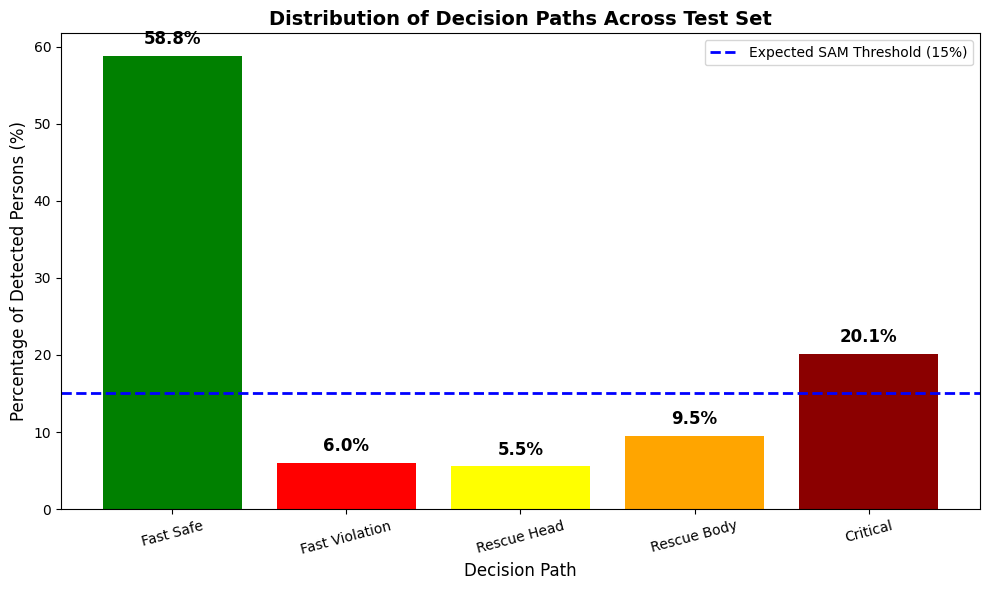

FileNotFoundError: No such file or directory: 'sam_activation_distribution.png'

FileNotFoundError: No such file or directory: 'sam_activation_distribution.png'

<IPython.core.display.Image object>

In [20]:
# 1. Run cells 1-3.1 to initialize the enhanced detector

# 2. Prepare your test images
test_dir = '/content/ppeconstruction/images/val'  # Change to your path

# 3. Run the analysis
test_results = run_path_analysis_on_testset(test_dir)
path_counts, sam_rate = analyze_sam_activation(test_results)

# 4. View the generated chart
from IPython.display import Image, display
display(Image('sam_activation_distribution.png'))